In [35]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [36]:
def spark_to_arrays(df):
        pandasDf = df.toPandas()
        X = np.array([row.toArray() for row in pandasDf['features']])
        y = pandasDf['label'].values
        return X, y

In [37]:
def load_data():
    from pyspark.sql import SparkSession
    spark = SparkSession.builder.appName("Diabetic Retinopathy: Scikit learn model training").master("spark://spark-master:7077").config("spark.executor.memory", "2g").config("spark.driver.memory", "2g").config("spark.sql.execution.arrow.pyspark.enabled", "true").getOrCreate()
    
    train_spark = spark.read.parquet('/home/data/processed/train')
    val_spark = spark.read.parquet('/home/data/processed/val')
    test_spark = spark.read.parquet('/home/data/processed/test')
    
    X_train, y_train = spark_to_arrays(train_spark)
    X_val, y_val = spark_to_arrays(val_spark)
    X_test, y_test = spark_to_arrays(test_spark)
    
    X_train = np.vstack([X_train, X_val])
    y_train = np.hstack([y_train, y_val])
    
    print(f"Train: {X_train.shape}")
    print(f"Test: {X_test.shape}")
    
    spark.stop()
    
    return X_train, y_train, X_test, y_test

In [38]:
def train_sklearn_logistic_regression(X_train, y_train, X_test, y_test):

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    
    param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'saga']
    }
    
    grid_search = GridSearchCV(
        lr, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1
    )

    start_time = datetime.now()
    grid_search.fit(X_train_scaled, y_train)
    end_time = datetime.now()
    
    training_time = (end_time - start_time).total_seconds()
    
    best_model = grid_search.best_estimator_
    print(f"Meilleurs paramètres: {grid_search.best_params_}")
    
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    
    metrics = calculate_metrics(y_test, y_pred, y_pred_proba, "Logistic Regression")
    metrics['training_time'] = training_time
    
    return best_model, scaler, metrics

In [39]:
def train_sklearn_random_forest(X_train, y_train, X_test, y_test):
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
    
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5]
    }
    
    grid_search = GridSearchCV(
        rf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1
    )
    
    start_time = datetime.now()
    grid_search.fit(X_train_scaled, y_train)
    end_time = datetime.now()
    
    training_time = (end_time - start_time).total_seconds()

    best_model = grid_search.best_estimator_
    print(f"Meilleurs paramètres: {grid_search.best_params_}")
    
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    
    metrics = calculate_metrics(y_test, y_pred, y_pred_proba, "Random Forest")
    metrics['training_time'] = training_time
    
    return best_model,scaler, metrics

In [40]:
def train_sklearn_svm(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    svm = SVC(probability=True, random_state=42, class_weight='balanced')
    
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
    
    grid_search = GridSearchCV(
        svm, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1
    )
    
    start_time = datetime.now()
    grid_search.fit(X_train_scaled, y_train)
    end_time = datetime.now()
    
    training_time = (end_time - start_time).total_seconds()
    
    best_model = grid_search.best_estimator_
    print(f"Meilleurs paramètres: {grid_search.best_params_}")
    
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    
    metrics = calculate_metrics(y_test, y_pred, y_pred_proba, "Linear SVM")
    metrics['training_time'] = training_time
    
    return best_model, scaler, metrics


In [41]:
def calculate_metrics(y_true, y_pred, y_pred_proba, model_name):
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    auc = roc_auc_score(y_true, y_pred_proba)
    
    metrics = {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc
    }
    
    print("Rapport de classification:")
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    print("Matrice de confusion:")
    print(cm)
    
    # Sauvegarder la matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Négatif (0)', 'Positif (1-4)'],
                yticklabels=['Négatif (0)', 'Positif (1-4)'])
    plt.title(f'Matrice de Confusion - {model_name}')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    
    return metrics

In [42]:
def save_sklearn_model(model, scaler, model_name):
    os.makedirs('/home/models', exist_ok=True)
    
    model_path = f'/home/models/sklearn_{model_name}_model.pkl'
    joblib.dump(model, model_path)
    print(f"Modèle sauvegardé: {model_path}")
    
    scaler_path = f'/home/models/sklearn_{model_name}_scaler.pkl'
    joblib.dump(scaler, scaler_path)
    print(f"Scaler sauvegardé: {scaler_path}")

In [43]:
def visualize_comparison(spark_results, sklearn_results):
    comparison_data = []
    
    for spark_metric in spark_results:
        comparison_data.append({
            'Model': spark_metric['model'],
            'Framework': 'Spark MLlib',
            'Accuracy': spark_metric['accuracy'],
            'F1-Score': spark_metric['f1_score'],
            'AUC-ROC': spark_metric['auc_roc'],
            'Training Time': spark_metric['training_time']
        })
    
    for sklearn_metric in sklearn_results:
        comparison_data.append({
            'Model': sklearn_metric['model'],
            'Framework': 'scikit-learn',
            'Accuracy': sklearn_metric['accuracy'],
            'F1-Score': sklearn_metric['f1_score'],
            'AUC-ROC': sklearn_metric['auc_roc'],
            'Training Time': sklearn_metric['training_time']
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    metrics_to_plot = ['Accuracy', 'F1-Score', 'AUC-ROC', 'Training Time']
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        
        pivot_data = df_comparison.pivot(index='Model', columns='Framework', values=metric)
        pivot_data.plot(kind='bar', ax=ax)
        
        ax.set_title(f'Comparaison: {metric}')
        ax.set_xlabel('Modèle')
        ax.set_ylabel(metric)
        ax.legend(title='Framework')
        ax.grid(axis='y', alpha=0.3)
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    return df_comparison

In [44]:
X_train, y_train, X_test, y_test = load_data()

/opt/spark/python/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/opt/spark/python/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/opt/spark/python/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow 

Train: (5958, 42)
Test: (1415, 42)


In [45]:
sklearn_results = []

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Meilleurs paramètres: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Rapport de classification:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       689
           1       0.93      0.90      0.91       726

    accuracy                           0.91      1415
   macro avg       0.91      0.91      0.91      1415
weighted avg       0.91      0.91      0.91      1415

Matrice de confusion:
[[638  51]
 [ 72 654]]
Modèle sauvegardé: /home/models/sklearn_logistic_regression_model.pkl
Scaler sauvegardé: /home/models/sklearn_logistic_regression_scaler.pkl


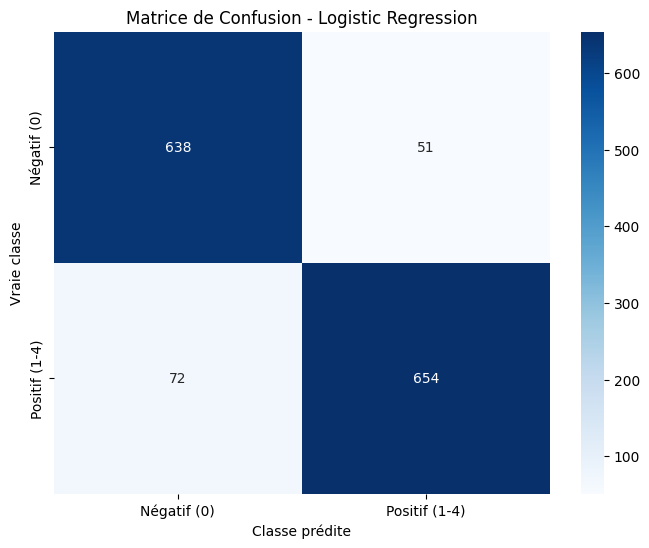

In [46]:
# Logistic Regression
lr_model, lr_scaler, lr_metrics = train_sklearn_logistic_regression(
    X_train, y_train, X_test, y_test
)
sklearn_results.append(lr_metrics)
save_sklearn_model(lr_model, lr_scaler, "logistic_regression")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Meilleurs paramètres: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Rapport de classification:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       689
           1       1.00      0.99      1.00       726

    accuracy                           1.00      1415
   macro avg       1.00      1.00      1.00      1415
weighted avg       1.00      1.00      1.00      1415

Matrice de confusion:
[[687   2]
 [  5 721]]
Modèle sauvegardé: /home/models/sklearn_random_forest_model.pkl
Scaler sauvegardé: /home/models/sklearn_random_forest_scaler.pkl


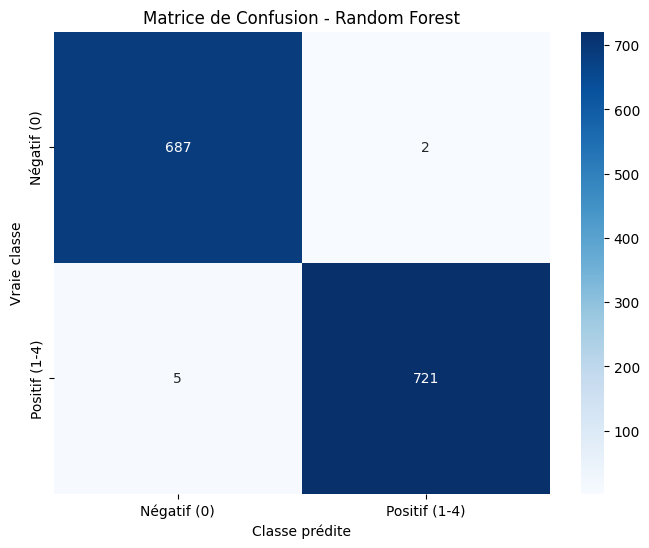

In [47]:
# Random Forest
rf_model, _, rf_metrics = train_sklearn_random_forest(
    X_train, y_train, X_test, y_test
)
sklearn_results.append(rf_metrics)
save_sklearn_model(rf_model, None, "random_forest")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Meilleurs paramètres: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Rapport de classification:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       689
           1       0.98      0.97      0.97       726

    accuracy                           0.97      1415
   macro avg       0.97      0.97      0.97      1415
weighted avg       0.97      0.97      0.97      1415

Matrice de confusion:
[[675  14]
 [ 24 702]]
Modèle sauvegardé: /home/models/sklearn_svm_model.pkl
Scaler sauvegardé: /home/models/sklearn_svm_scaler.pkl


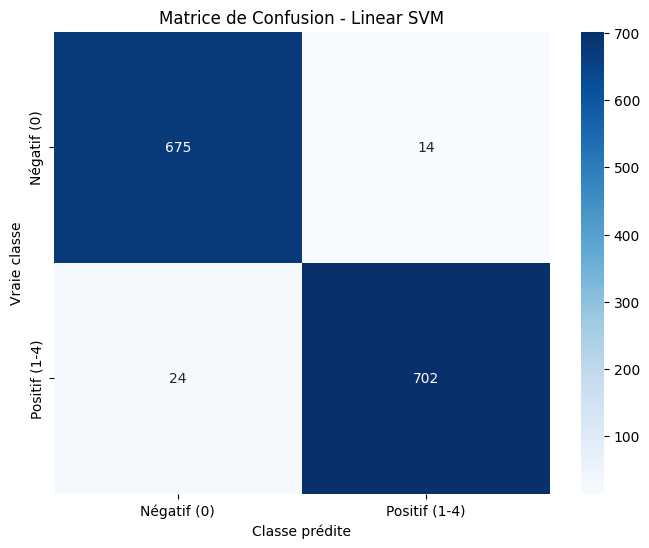

In [48]:
# SVM
svm_model, svm_scaler, svm_metrics = train_sklearn_svm(
    X_train, y_train, X_test, y_test
)
sklearn_results.append(svm_metrics)
save_sklearn_model(svm_model, svm_scaler, "svm")  

In [49]:
sklearn_df = pd.DataFrame(sklearn_results)
sklearn_df.to_csv('/home/models/sklearn_results.csv', index=False)
print(sklearn_df.to_string(index=False))

              model  accuracy  precision   recall  f1_score  auc_roc  training_time
Logistic Regression  0.913074   0.913506 0.913074  0.913089 0.961401       4.517964
      Random Forest  0.995053   0.995062 0.995053  0.995053 0.999196      12.665933
         Linear SVM  0.973145   0.973249 0.973145  0.973148 0.992887      22.211253


Comparaison Spark et Scikit-learn
              Model    Framework  Accuracy  F1-Score  AUC-ROC  Training Time
Logistic Regression  Spark MLlib  0.903180  0.903176 0.958584      64.481295
      Random Forest  Spark MLlib  0.954770  0.954776 0.990069      12.353443
         Linear SVM  Spark MLlib  0.861484  0.861410 0.939436       8.513320
Logistic Regression scikit-learn  0.913074  0.913089 0.961401       4.517964
      Random Forest scikit-learn  0.995053  0.995053 0.999196      12.665933
         Linear SVM scikit-learn  0.973145  0.973148 0.992887      22.211253


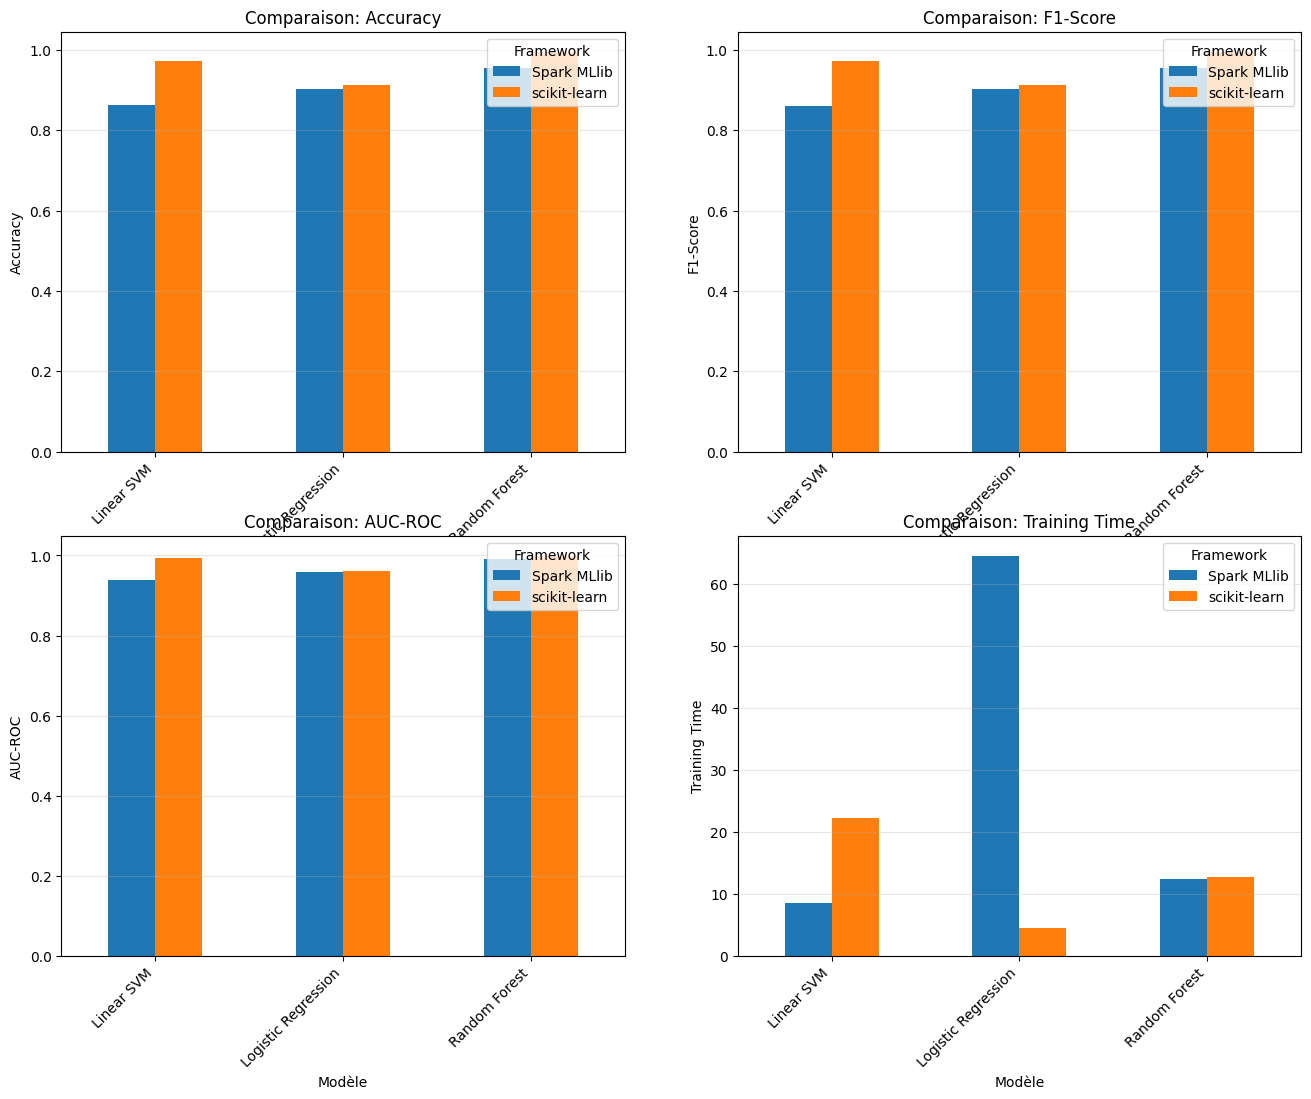

In [50]:
# Charger les résultats Spark pour comparaison
spark_df = pd.read_csv('/home/models/spark_results.csv')
spark_results = spark_df.to_dict('records')
        
comparison_df = visualize_comparison(spark_results, sklearn_results)
        
print("Comparaison Spark et Scikit-learn")
print(comparison_df.to_string(index=False))